# Beyin Tümör Sınıflandırması

Bu çalışmada, beyin tümörleri olan ve olmayan insanların MR görüntülerinin toplanmış olduğu veri setinden, bir insanın beyninde tümör var mı? Varsa hangi tümör sınıfına girdiğine dair sınıflandırma ve tahmin yapılmıştır. 

Eğitim ve Test Veri setleri 4 sınıfa ayrılmıştır. Bu sınıflar; 
* No Tümör
* Pituitary Tümör  
* Meningioma Tümör 
* Glioma Tümör

### Verileri çekebilmek için drive'ın mount edilmesi

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Gerekli Kütüphanelerin Import Edilmesi

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#EfficientNetV2S
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
#!pip install tf-nightly
#!pip install keras_efficientnets
#!pip install pretty-confusion-matrix

## Verilerin Çekilmesi ve Etiketlerin(Labels) Oluşturulması

In [ ]:
classes=[]
filename='/gdrive/MyDrive/Colab Notebooks/BrainTumor/'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']


# Verilerin Yeniden Boyutlandırılması ve Boyutlandırılmış Verilerin Listeye Eklenmesi

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #İlerlemenin gösterilmesi için tqdm kütüphanesi ile bir döngü oluşuturlması. 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        


100%|██████████| 100/100 [00:00<00:00, 204.09it/s]


In [ ]:
#Eğitim setlerinin diziye dönüştürülmesi
X_train = np.array(X_train)
y_train = np.array(y_train)    

# Data Augmentation(Veri Artırma/Büyütme) ve Bölme 

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #Görüntüler üzerinde gerçekleştirilecek rastgele rotasyonlar için derece aralığının atanması
    width_shift_range=0.05,
    height_shift_range=0.05, #Görüntüyü yatay ve dikey olarak kaydırma
    zoom_range=0.1, #resimleri zoomlama
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#Eğitim(Train) ve Test Setlerinin Bölünmesi 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

## EfficientNetB3 Modeli

* EfficientNet Modeli, state-of-the-art modelidir. Evrişimli sinir ağı modeli de denebilir. Kısaca, bazı ölçeklendirmeler yaparak daha doğru ve verimli sonuçlar almak için kullanılan bir model diyebiliriz.

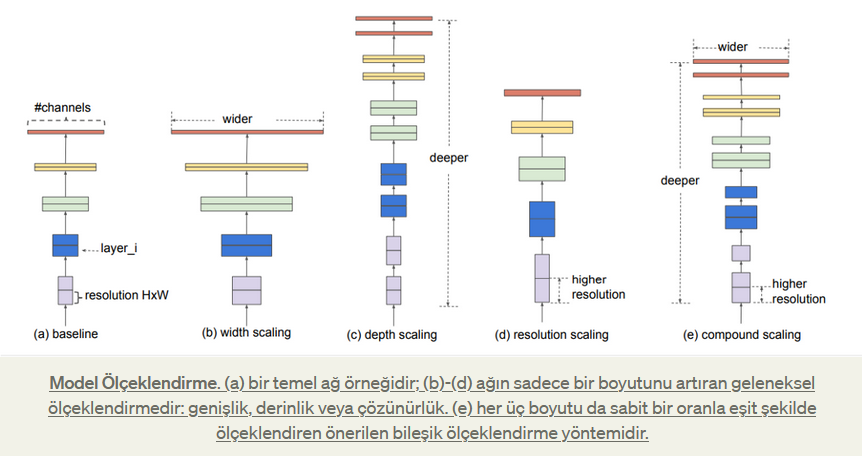

In [ ]:
print(y_train)

# EfficientNet yüklemesi
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

[3 1 1 ... 3 3 0]


# EfficentNet Modelinin Oluşturulması 

In [ ]:
tf.random.set_seed(45)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

#Modeli Derleme
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# Modelin Özetini Görüntüleme
print(model.summary())

early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True) #Modelin ezberlememesi için Early Stopping kullanılması.



Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 150, 150, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 150, 150, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                           

# EfficentNet Modelinin Eğitilmesi

In [ ]:
history_efficent = model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=90,
    batch_size=13,callbacks=early_stopping_cb)

Epoch 1/90
214/214 [==============================] - 47s 153ms/step - loss: 1.3077 - accuracy: 0.4193 - val_loss: 1.2141 - val_accuracy: 0.4653
Epoch 2/90
214/214 [==============================] - 29s 135ms/step - loss: 0.8912 - accuracy: 0.6478 - val_loss: 0.8681 - val_accuracy: 0.6878
Epoch 3/90
214/214 [==============================] - 29s 137ms/step - loss: 0.7133 - accuracy: 0.7278 - val_loss: 0.5208 - val_accuracy: 0.8429
Epoch 4/90
214/214 [==============================] - 29s 135ms/step - loss: 0.5789 - accuracy: 0.7884 - val_loss: 0.3955 - val_accuracy: 0.8878
Epoch 5/90
214/214 [==============================] - 30s 139ms/step - loss: 0.4925 - accuracy: 0.8187 - val_loss: 0.3442 - val_accuracy: 0.9000
Epoch 6/90
214/214 [==============================] - 29s 135ms/step - loss: 0.4467 - accuracy: 0.8435 - val_loss: 0.2923 - val_accuracy: 0.9143
Epoch 7/90
214/214 [==============================] - 30s 138ms/step - loss: 0.3745 - accuracy: 0.8663 - val_loss: 0.2621 - val_ac

# VGG16 Modeli
*  Basit bir ağ modeli olup öncesindeki modellerden en önemli farkı evrişim katmalarının 2'li ya da 3'li kullanılmasıdır. Tam bağlantı (FC) katmanında 7x7x512=4096 nöronlu bir öznitelik vektörüne dönüştürülür. İki FC katmanı çıkışında 1000 sınıflı softmax başarımı hesaplanır.Diğer modellerde olduğu gibi girişten çıkışa doğru matrislerin yükseklik ve genişlik boyutları azalırken derinlik değeri (kanal sayısı) artmaktadır.

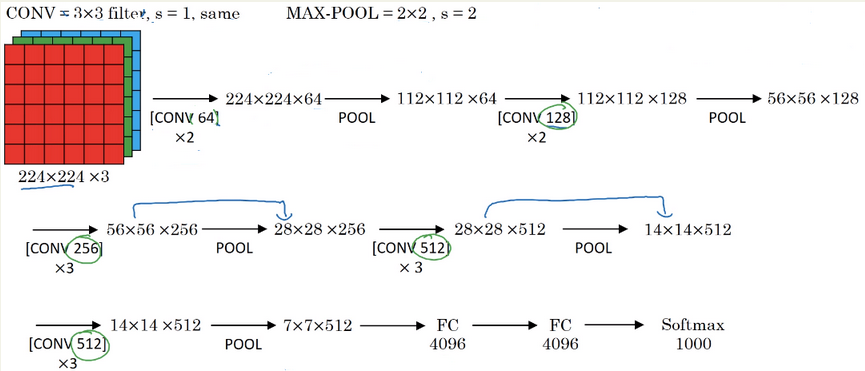

In [ ]:
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D
from keras.applications.vgg16 import VGG16

base_model=VGG16(input_shape=(image_size,image_size,3),include_top=False,weights='imagenet')

x=Flatten()(base_model.output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(1024,activation='relu')(x)
out=Dense(4,activation='softmax')(x)

model_vgg=Model(inputs=base_model.inputs,outputs=out)
for layer in model_vgg.layers[:22]:
  layer.trainable=False

for layer in model_vgg.layers:
  print(layer.name," ",layer.trainable)
model_vgg.summary()

input_8   False
block1_conv1   False
block1_conv2   False
block1_pool   False
block2_conv1   False
block2_conv2   False
block2_pool   False
block3_conv1   False
block3_conv2   False
block3_conv3   False
block3_pool   False
block4_conv1   False
block4_conv2   False
block4_conv3   False
block4_pool   False
block5_conv1   False
block5_conv2   False
block5_conv3   False
block5_pool   False
flatten_1   False
dense_28   False
dropout_8   False
dense_29   True
dense_30   True
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                              

# VGG16 Modelinin Derlenmesi ve Eğitilmesi

In [ ]:
model_vgg.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
history_vgg = model_vgg.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=90,
    batch_size=13,callbacks=early_stopping_cb)

Epoch 1/90
214/214 [==============================] - 14s 56ms/step - loss: 3.9218 - accuracy: 0.5519 - val_loss: 1.4750 - val_accuracy: 0.7551
Epoch 2/90
214/214 [==============================] - 10s 46ms/step - loss: 1.9603 - accuracy: 0.6986 - val_loss: 1.2946 - val_accuracy: 0.7694
Epoch 3/90
214/214 [==============================] - 10s 46ms/step - loss: 1.6951 - accuracy: 0.7311 - val_loss: 1.2159 - val_accuracy: 0.7776
Epoch 4/90
214/214 [==============================] - 10s 46ms/step - loss: 1.4363 - accuracy: 0.7563 - val_loss: 0.8979 - val_accuracy: 0.8204
Epoch 5/90
214/214 [==============================] - 10s 46ms/step - loss: 1.3653 - accuracy: 0.7495 - val_loss: 1.1151 - val_accuracy: 0.8000
Epoch 6/90
214/214 [==============================] - 10s 47ms/step - loss: 1.1311 - accuracy: 0.7761 - val_loss: 0.8424 - val_accuracy: 0.8327
Epoch 7/90
214/214 [==============================] - 10s 47ms/step - loss: 1.1258 - accuracy: 0.7758 - val_loss: 0.8384 - val_accuracy:

# ResNet Modeli
* ResNet ağı, VGG-19 mimarisinden esas alınarak VGG ağlarından daha az filtreye ve daha düşük karmaşıklığa sahip 34 katmanlı düz bir ağ mimarisi kullanır. Daha sonra bu düz ağa atlama bağlantıları veya artık bloklar eklenerek mimari artık ağa dönüştürülür.

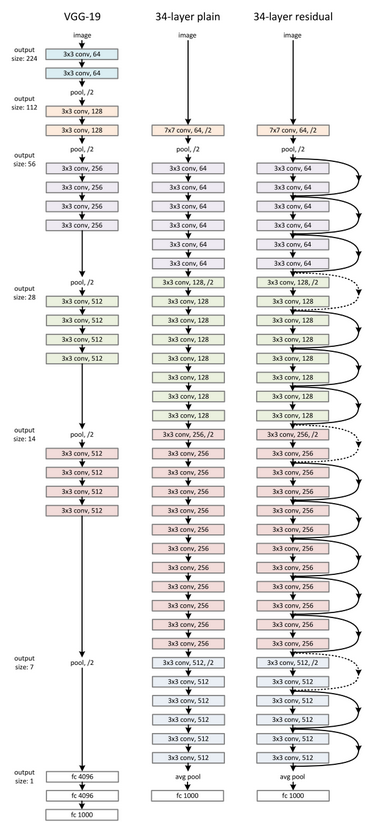

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
from keras.applications import ResNet152V2
resnet = ResNet152V2(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3)) #Kurulum

### ResNet Modelinin Oluşturulması

In [ ]:
model_resnet = resnet.output
model_resnet = tf.keras.layers.GlobalAveragePooling2D()(model_resnet)
model_resnet = tf.keras.layers.Dropout(rate=0.5)(model_resnet)
model_resnet = tf.keras.layers.Dense(4,activation='softmax')(model_resnet)
model_resnet = tf.keras.models.Model(inputs=resnet.input, outputs = model_resnet)

model_resnet.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']      

### ResNet Modelinin Derlenmesi ve Eğitilmesi

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
model_resnet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
history_resnet = model_resnet.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=100,
    batch_size=13,callbacks=early_stopping_cb)

Epoch 1/100
214/214 [==============================] - 64s 233ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0898 - val_accuracy: 0.9755
Epoch 2/100
214/214 [==============================] - 45s 212ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0930 - val_accuracy: 0.9714
Epoch 3/100
214/214 [==============================] - 46s 213ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.1122 - val_accuracy: 0.9612
Epoch 4/100
214/214 [==============================] - 46s 214ms/step - loss: 0.0084 - accuracy: 0.9986 - val_loss: 0.1358 - val_accuracy: 0.9633
Epoch 5/100
214/214 [==============================] - 45s 212ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.1405 - val_accuracy: 0.9592
Epoch 6/100
214/214 [==============================] - 45s 212ms/step - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.1325 - val_accuracy: 0.9673
Epoch 7/100
214/214 [==============================] - 45s 213ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.1662 -

# DenseNet201 Modeli

* Her katmanı diğer tüm katmanlara ileri beslemeli bir şekilde bağlar. Kaybolan gradyan sorununu hafifletir, özellik yayılımını güçlendirir, özelliklerin yeniden kullanımını teşvik eder ve parametre sayısını önemli ölçüde azaltır.

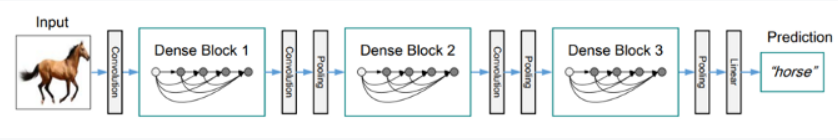
 

In [ ]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(image_size,image_size,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

In [ ]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(256, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(4, activation='softmax')(x3)
model_denseNet = tf.keras.Model(inputs=inputs3, outputs=outputs3)
model_denseNet.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_denseNet=model_denseNet.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=100, batch_size=13,callbacks=early_stopping_cb)

Epoch 1/100
214/214 [==============================] - 29s 75ms/step - loss: 1.7541 - accuracy: 0.5789 - val_loss: 0.7328 - val_accuracy: 0.7408
Epoch 2/100
214/214 [==============================] - 11s 51ms/step - loss: 0.6643 - accuracy: 0.7498 - val_loss: 0.6705 - val_accuracy: 0.6980
Epoch 3/100
214/214 [==============================] - 10s 45ms/step - loss: 0.5646 - accuracy: 0.7826 - val_loss: 0.5489 - val_accuracy: 0.7673
Epoch 4/100
214/214 [==============================] - 11s 50ms/step - loss: 0.5166 - accuracy: 0.7963 - val_loss: 0.9161 - val_accuracy: 0.6673
Epoch 5/100
214/214 [==============================] - 10s 48ms/step - loss: 0.4359 - accuracy: 0.8237 - val_loss: 0.4687 - val_accuracy: 0.8224
Epoch 6/100
214/214 [==============================] - 11s 51ms/step - loss: 0.4006 - accuracy: 0.8371 - val_loss: 0.4552 - val_accuracy: 0.8265
Epoch 7/100
214/214 [==============================] - 9s 44ms/step - loss: 0.3830 - accuracy: 0.8486 - val_loss: 0.5172 - val_acc

# Inception V3 Modeli 

* Inception V3 bir tür konvolüsyonel nöral ağ modelidir. Çok sayıda konvolüsyon ve maksimum havuzlama adımlarından oluşmaktadır. Son aşamada ise tam bağlı nöral ağ içermektedir. 

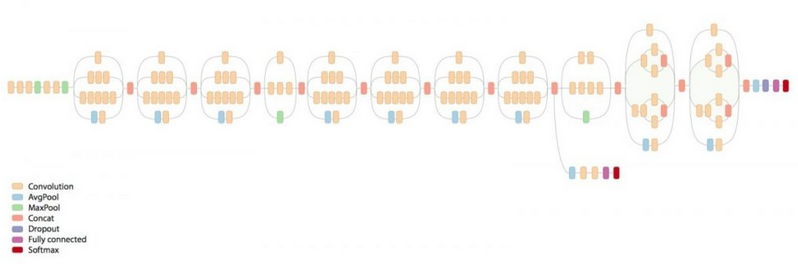

In [ ]:
from keras.applications import InceptionV3 , mobilenet,mobilenet_v2

pre_model = InceptionV3(
        input_shape=(image_size,image_size,3),
        weights='imagenet',   
        include_top=False,) 

for layers in pre_model.layers:
    layers.trainable=False

last_layer = pre_model.get_layer('mixed7')
last_output = last_layer.output

### Inception V3 Modelinin Oluşturulması ve Derlenmesi

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(4,activation='softmax')(x)

model_inception = Model(pre_model.input,output)

model_inception.compile(optimizer=Adam(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

### Inception V3 Modelinin Eğitilmesi

In [ ]:
history_inception=model_inception.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=100, batch_size=13,callbacks=early_stopping_cb)

Epoch 1/100
214/214 [==============================] - 11s 32ms/step - loss: 1.0133 - accuracy: 0.6074 - val_loss: 0.9374 - val_accuracy: 0.6245
Epoch 2/100
214/214 [==============================] - 4s 20ms/step - loss: 0.7078 - accuracy: 0.7192 - val_loss: 0.7084 - val_accuracy: 0.7612
Epoch 3/100
214/214 [==============================] - 4s 20ms/step - loss: 0.5821 - accuracy: 0.7776 - val_loss: 0.4598 - val_accuracy: 0.8224
Epoch 4/100
214/214 [==============================] - 4s 20ms/step - loss: 0.4348 - accuracy: 0.8338 - val_loss: 0.5193 - val_accuracy: 0.8245
Epoch 5/100
214/214 [==============================] - 4s 20ms/step - loss: 0.4164 - accuracy: 0.8392 - val_loss: 0.6888 - val_accuracy: 0.7653
Epoch 6/100
214/214 [==============================] - 4s 20ms/step - loss: 0.3564 - accuracy: 0.8634 - val_loss: 0.3744 - val_accuracy: 0.8592
Epoch 7/100
214/214 [==============================] - 4s 20ms/step - loss: 0.2885 - accuracy: 0.8893 - val_loss: 0.8166 - val_accuracy

In [ ]:
# Y kümesinin train ve test boyutlarının kontrolü
#y_train.shape,y_test.shape

# Modellerin Sonuçlarının Grafikle Gösterilmesi

* EfficentNet

16/16 [==============================] - 1s 62ms/step - loss: 0.1234 - accuracy: 0.9612
Accuracy: 96.122450


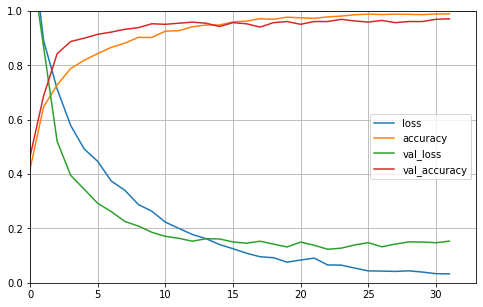

In [ ]:
# loss ve accuracy grafiğinin çizdirilmesi
pd.DataFrame(history_efficent.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
#plt.savefig('/gdrive/MyDrive/Colab Notebooks/BrainTumor/train_model(efficentNetB3).h5')
loss_efficent, accuracy_efficent = model.evaluate(X_test,y_test)
    
print('Accuracy: %f' % (accuracy_efficent*100))


* ResNet

16/16 [==============================] - 2s 123ms/step - loss: 0.0898 - accuracy: 0.9755
Accuracy: 97.551018


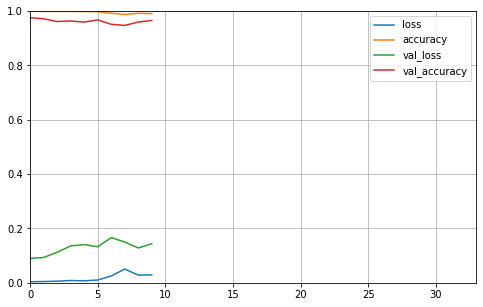

In [ ]:
# loss ve accuracy grafiğinin çizdirilmesi
pd.DataFrame(history_resnet.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test,y_test)
    
print('Accuracy: %f' % (accuracy_resnet*100))

* VGG16

16/16 [==============================] - 1s 76ms/step - loss: 0.3750 - accuracy: 0.9061
Accuracy: 90.612245


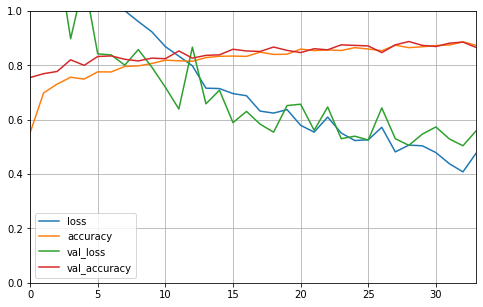

In [ ]:
# loss ve accuracy grafiğinin çizdirilmesi
pd.DataFrame(history_vgg.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
loss_vgg, accuracy_vgg = model_vgg.evaluate(X_test,y_test)
    
print('Accuracy: %f' % (accuracy_vgg*100))

* DenseNet

16/16 [==============================] - 1s 80ms/step - loss: 0.3096 - accuracy: 0.8816
Accuracy: 88.163263


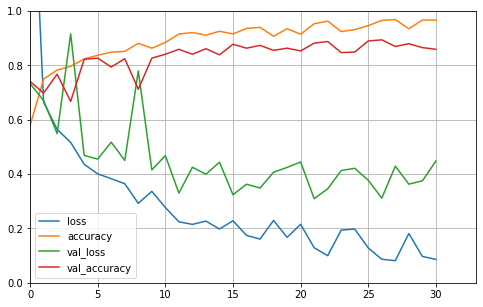

In [ ]:
# loss ve accuracy grafiğinin çizdirilmesi
pd.DataFrame(history_denseNet.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
loss_denseNet, accuracy_denseNet = model_denseNet.evaluate(X_test,y_test)
    
print('Accuracy: %f' % (accuracy_denseNet*100))

* Inception V3

16/16 [==============================] - 1s 35ms/step - loss: 0.2333 - accuracy: 0.9184
Accuracy: 91.836733


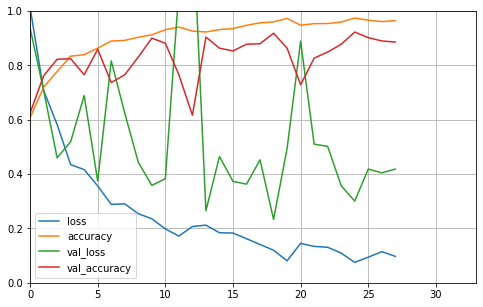

In [ ]:
# loss ve accuracy grafiğinin çizdirilmesi
pd.DataFrame(history_inception.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
loss_inception, accuracy_inception = model_inception.evaluate(X_test,y_test)
    
print('Accuracy: %f' % (accuracy_inception*100))

### Modellerin Kayıp ve Başarı Oranlarının Yazdırılması

In [ ]:
#EfficentNet
#model.summary() # Model Özeti
loss, accuracy = model.evaluate(X_test,y_test) 
print("------------------------------------------------------------------------------------------")
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

16/16 [==============================] - 1s 63ms/step - loss: 0.1234 - accuracy: 0.9612
----------------------------------
accuracy : 96.122 
 loss : 0.123


In [ ]:
loss, accuracy = model_resnet.evaluate(X_test,y_test) 
print("------------------------------------------------------------------------------------------")
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

16/16 [==============================] - 2s 124ms/step - loss: 0.0898 - accuracy: 0.9755
------------------------------------------------------------------------------------------
accuracy : 97.551 
 loss : 0.09


In [ ]:
loss, accuracy = model_vgg.evaluate(X_test,y_test) 
print("------------------------------------------------------------------------------------------")
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

16/16 [==============================] - 1s 76ms/step - loss: 0.3750 - accuracy: 0.9061
------------------------------------------------------------------------------------------
accuracy : 90.612 
 loss : 0.375


In [ ]:
loss, accuracy = model_denseNet.evaluate(X_test,y_test) 
print("------------------------------------------------------------------------------------------")
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

16/16 [==============================] - 1s 83ms/step - loss: 0.3096 - accuracy: 0.8816
------------------------------------------------------------------------------------------
accuracy : 88.163 
 loss : 0.31


In [ ]:
loss, accuracy = model_inception.evaluate(X_test,y_test) 
print("------------------------------------------------------------------------------------------")
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

16/16 [==============================] - 1s 34ms/step - loss: 0.2333 - accuracy: 0.9184
------------------------------------------------------------------------------------------
accuracy : 91.837 
 loss : 0.233


In [ ]:
# Model Hakkında Daha Fazla Detay Edinilmesi
'''
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   aktivasyon özelliği yok')

# Her katman hakkında özel bilgi 
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')


# Optimizer hakkında detaylı bilgi
model.optimizer.get_config()  '''

'\nfor i, layer in enumerate (model.layers):\n    print (i, layer)\n    try:\n        print ("    ",layer.activation)\n    except AttributeError:\n        print(\'   aktivasyon özelliği yok\')\n\n# Her katman hakkında özel bilgi \nfor i in range(len(model.layers)):\n    print(f\'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n\')\n\n\n# Optimizer hakkında detaylı bilgi\nmodel.optimizer.get_config()  '

# Tahmin 


* EfficentNet Modeli

In [ ]:
#EfficentNet
y_test_labels=lb.inverse_transform(y_test) # Test etiketlerinin alınması

# Tahmin Edilen Değerler 
pred_efficent=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred_efficent) # Tahmin edilen Etiketler

pd.Series(pred_labels).value_counts() # Her bir sınıfın kaçının doğru tahmin edildiğini verir.

16/16 [==============================] - 1s 60ms/step


meningioma_tumor    142
glioma_tumor        138
pituitary_tumor     133
no_tumor             77
dtype: int64

* ResNet Modeli

In [ ]:
y_test_labels=lb.inverse_transform(y_test) # Test etiketlerinin alınması

# Tahmin Edilen Değerler 
pred_resnet=np.argmax(model_resnet.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred_resnet) # Tahmin edilen Etiketler

pd.Series(pred_labels).value_counts()

16/16 [==============================] - 2s 120ms/step


meningioma_tumor    142
pituitary_tumor     135
glioma_tumor        134
no_tumor             79
dtype: int64

* VGG16 Modeli

In [ ]:
y_test_labels=lb.inverse_transform(y_test) # Test etiketlerinin alınması

# Tahmin Edilen Değerler 
pred_vgg=np.argmax(model_vgg.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred_vgg) # Tahmin edilen Etiketler

pd.Series(pred_labels).value_counts()

16/16 [==============================] - 1s 74ms/step


glioma_tumor        147
pituitary_tumor     140
meningioma_tumor    129
no_tumor             74
dtype: int64

* DenseNet Modeli

In [ ]:
y_test_labels=lb.inverse_transform(y_test) # Test etiketlerinin alınması

# Tahmin Edilen Değerler 
pred_denseNet=np.argmax(model_denseNet.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred_denseNet) # Tahmin edilen Etiketler

pd.Series(pred_labels).value_counts()

16/16 [==============================] - 1s 73ms/step


meningioma_tumor    151
pituitary_tumor     133
glioma_tumor        128
no_tumor             78
dtype: int64

* Inception V3 Modeli

In [ ]:
y_test_labels=lb.inverse_transform(y_test) # Test etiketlerinin alınması

# Tahmin Edilen Değerler 
pred_inception=np.argmax(model_inception.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred_inception) # Tahmin edilen Etiketler

pd.Series(pred_labels).value_counts()

16/16 [==============================] - 1s 29ms/step


meningioma_tumor    156
pituitary_tumor     139
glioma_tumor        121
no_tumor             74
dtype: int64

# Confusion Matrix ile Sonuçların Görselleştirilmesi

* EfficentNet Modeli

Text(70.8, 0.5, 'Tahmin Edilen Sınıf')

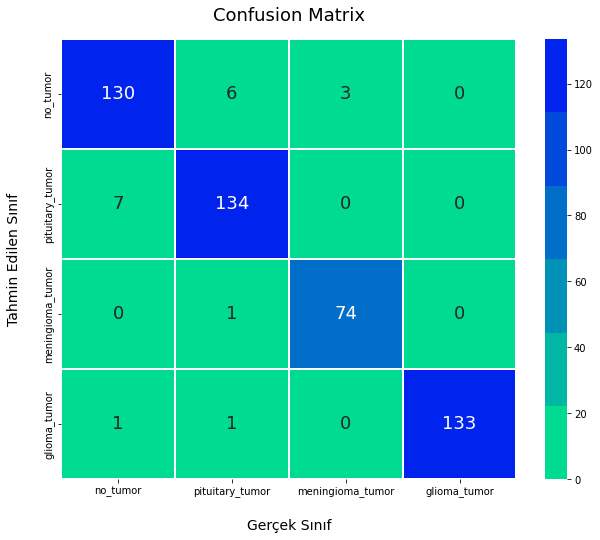

In [ ]:
cm = confusion_matrix(y_test,pred_efficent)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r paleti ters çevirmesi için
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Gerçek Sınıf',labelpad=22,fontsize=14)
plt.ylabel('Tahmin Edilen Sınıf',labelpad=22,fontsize=14)

* ResNet Modeli

Text(70.8, 0.5, 'Tahmin Edilen Sınıf')

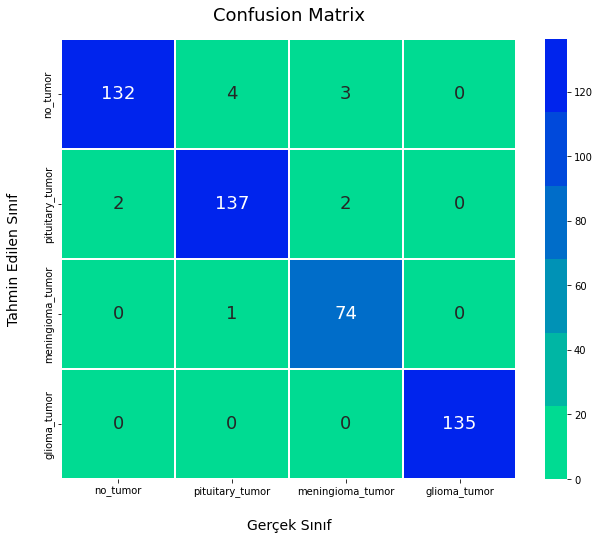

In [ ]:
cm = confusion_matrix(y_test,pred_resnet)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r paleti ters çevirmesi için
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Gerçek Sınıf',labelpad=22,fontsize=14)
plt.ylabel('Tahmin Edilen Sınıf',labelpad=22,fontsize=14)

* VGG16 Modeli

Text(70.8, 0.5, 'Tahmin Edilen Sınıf')

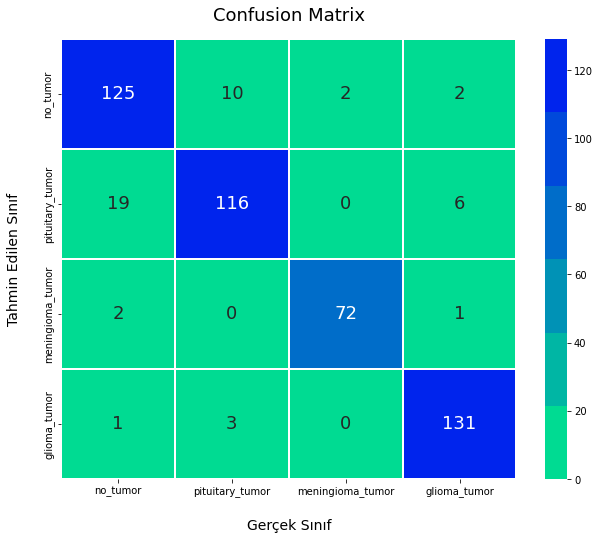

In [ ]:
cm = confusion_matrix(y_test,pred_vgg)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r paleti ters çevirmesi için
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Gerçek Sınıf',labelpad=22,fontsize=14)
plt.ylabel('Tahmin Edilen Sınıf',labelpad=22,fontsize=14)

* DenseNet Modeli

Text(70.8, 0.5, 'Tahmin Edilen Sınıf')

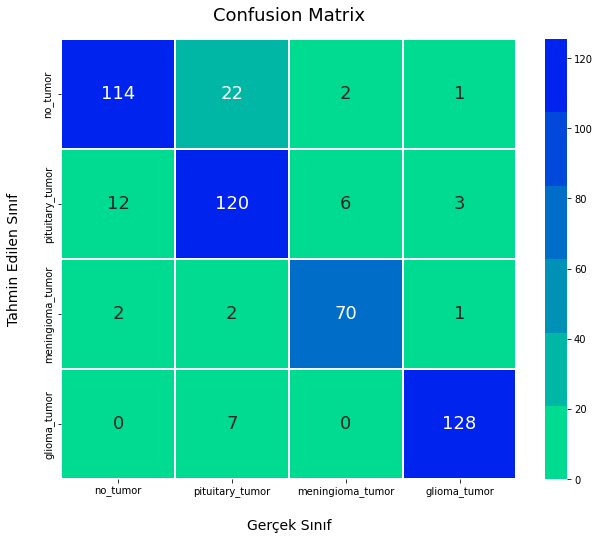

In [ ]:
cm = confusion_matrix(y_test,pred_denseNet)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r paleti ters çevirmesi için
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Gerçek Sınıf',labelpad=22,fontsize=14)
plt.ylabel('Tahmin Edilen Sınıf',labelpad=22,fontsize=14)

* Inception V3 Modeli

Text(70.8, 0.5, 'Tahmin Edilen Sınıf')

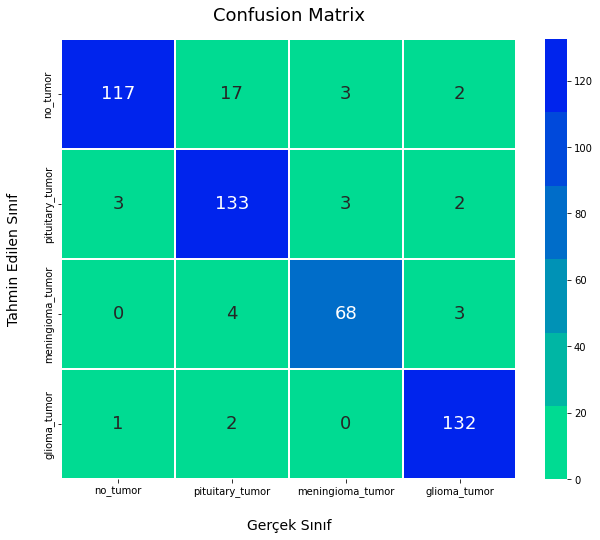

In [ ]:
cm = confusion_matrix(y_test,pred_inception)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r paleti ters çevirmesi için
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Gerçek Sınıf',labelpad=22,fontsize=14)
plt.ylabel('Tahmin Edilen Sınıf',labelpad=22,fontsize=14)

# Model Performans Tablosu

* EfficentNet

In [ ]:
print(classification_report(y_test,pred_efficent,target_names=classes))

                  precision    recall  f1-score   support

        no_tumor       0.94      0.94      0.94       139
 pituitary_tumor       0.94      0.95      0.95       141
meningioma_tumor       0.96      0.99      0.97        75
    glioma_tumor       1.00      0.99      0.99       135

        accuracy                           0.96       490
       macro avg       0.96      0.96      0.96       490
    weighted avg       0.96      0.96      0.96       490



* ResNet

In [ ]:
print(classification_report(y_test,pred_resnet,target_names=classes))

                  precision    recall  f1-score   support

        no_tumor       0.99      0.95      0.97       139
 pituitary_tumor       0.96      0.97      0.97       141
meningioma_tumor       0.94      0.99      0.96        75
    glioma_tumor       1.00      1.00      1.00       135

        accuracy                           0.98       490
       macro avg       0.97      0.98      0.97       490
    weighted avg       0.98      0.98      0.98       490



* VGG16

In [ ]:
print(classification_report(y_test,pred_vgg,target_names=classes))

                  precision    recall  f1-score   support

        no_tumor       0.85      0.90      0.87       139
 pituitary_tumor       0.90      0.82      0.86       141
meningioma_tumor       0.97      0.96      0.97        75
    glioma_tumor       0.94      0.97      0.95       135

        accuracy                           0.91       490
       macro avg       0.91      0.91      0.91       490
    weighted avg       0.91      0.91      0.91       490



* DenseNet

In [ ]:
print(classification_report(y_test,pred_denseNet,target_names=classes))

                  precision    recall  f1-score   support

        no_tumor       0.89      0.82      0.85       139
 pituitary_tumor       0.79      0.85      0.82       141
meningioma_tumor       0.90      0.93      0.92        75
    glioma_tumor       0.96      0.95      0.96       135

        accuracy                           0.88       490
       macro avg       0.89      0.89      0.89       490
    weighted avg       0.88      0.88      0.88       490



* Inception V3

In [ ]:
print(classification_report(y_test,pred_inception,target_names=classes))

                  precision    recall  f1-score   support

        no_tumor       0.97      0.84      0.90       139
 pituitary_tumor       0.85      0.94      0.90       141
meningioma_tumor       0.92      0.91      0.91        75
    glioma_tumor       0.95      0.98      0.96       135

        accuracy                           0.92       490
       macro avg       0.92      0.92      0.92       490
    weighted avg       0.92      0.92      0.92       490



In [ ]:
#os.getcwd()

# Veri Kümesinden ve Tahmin Edilen Sınıflardan Bazı Görüntüler

In [ ]:
import matplotlib.image as mpimg
os.chdir('/gdrive/MyDrive/Colab Notebooks/BrainTumor/')
TEST_DIR='Testing'
# Görüntüleri orijinal doğrulama veri kümesinden alıp, görüntüleri çizmek için yeniden boyutlandırma
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]

Testing/glioma_tumor
Testing/pituitary_tumor
Testing/meningioma_tumor
Testing/no_tumor


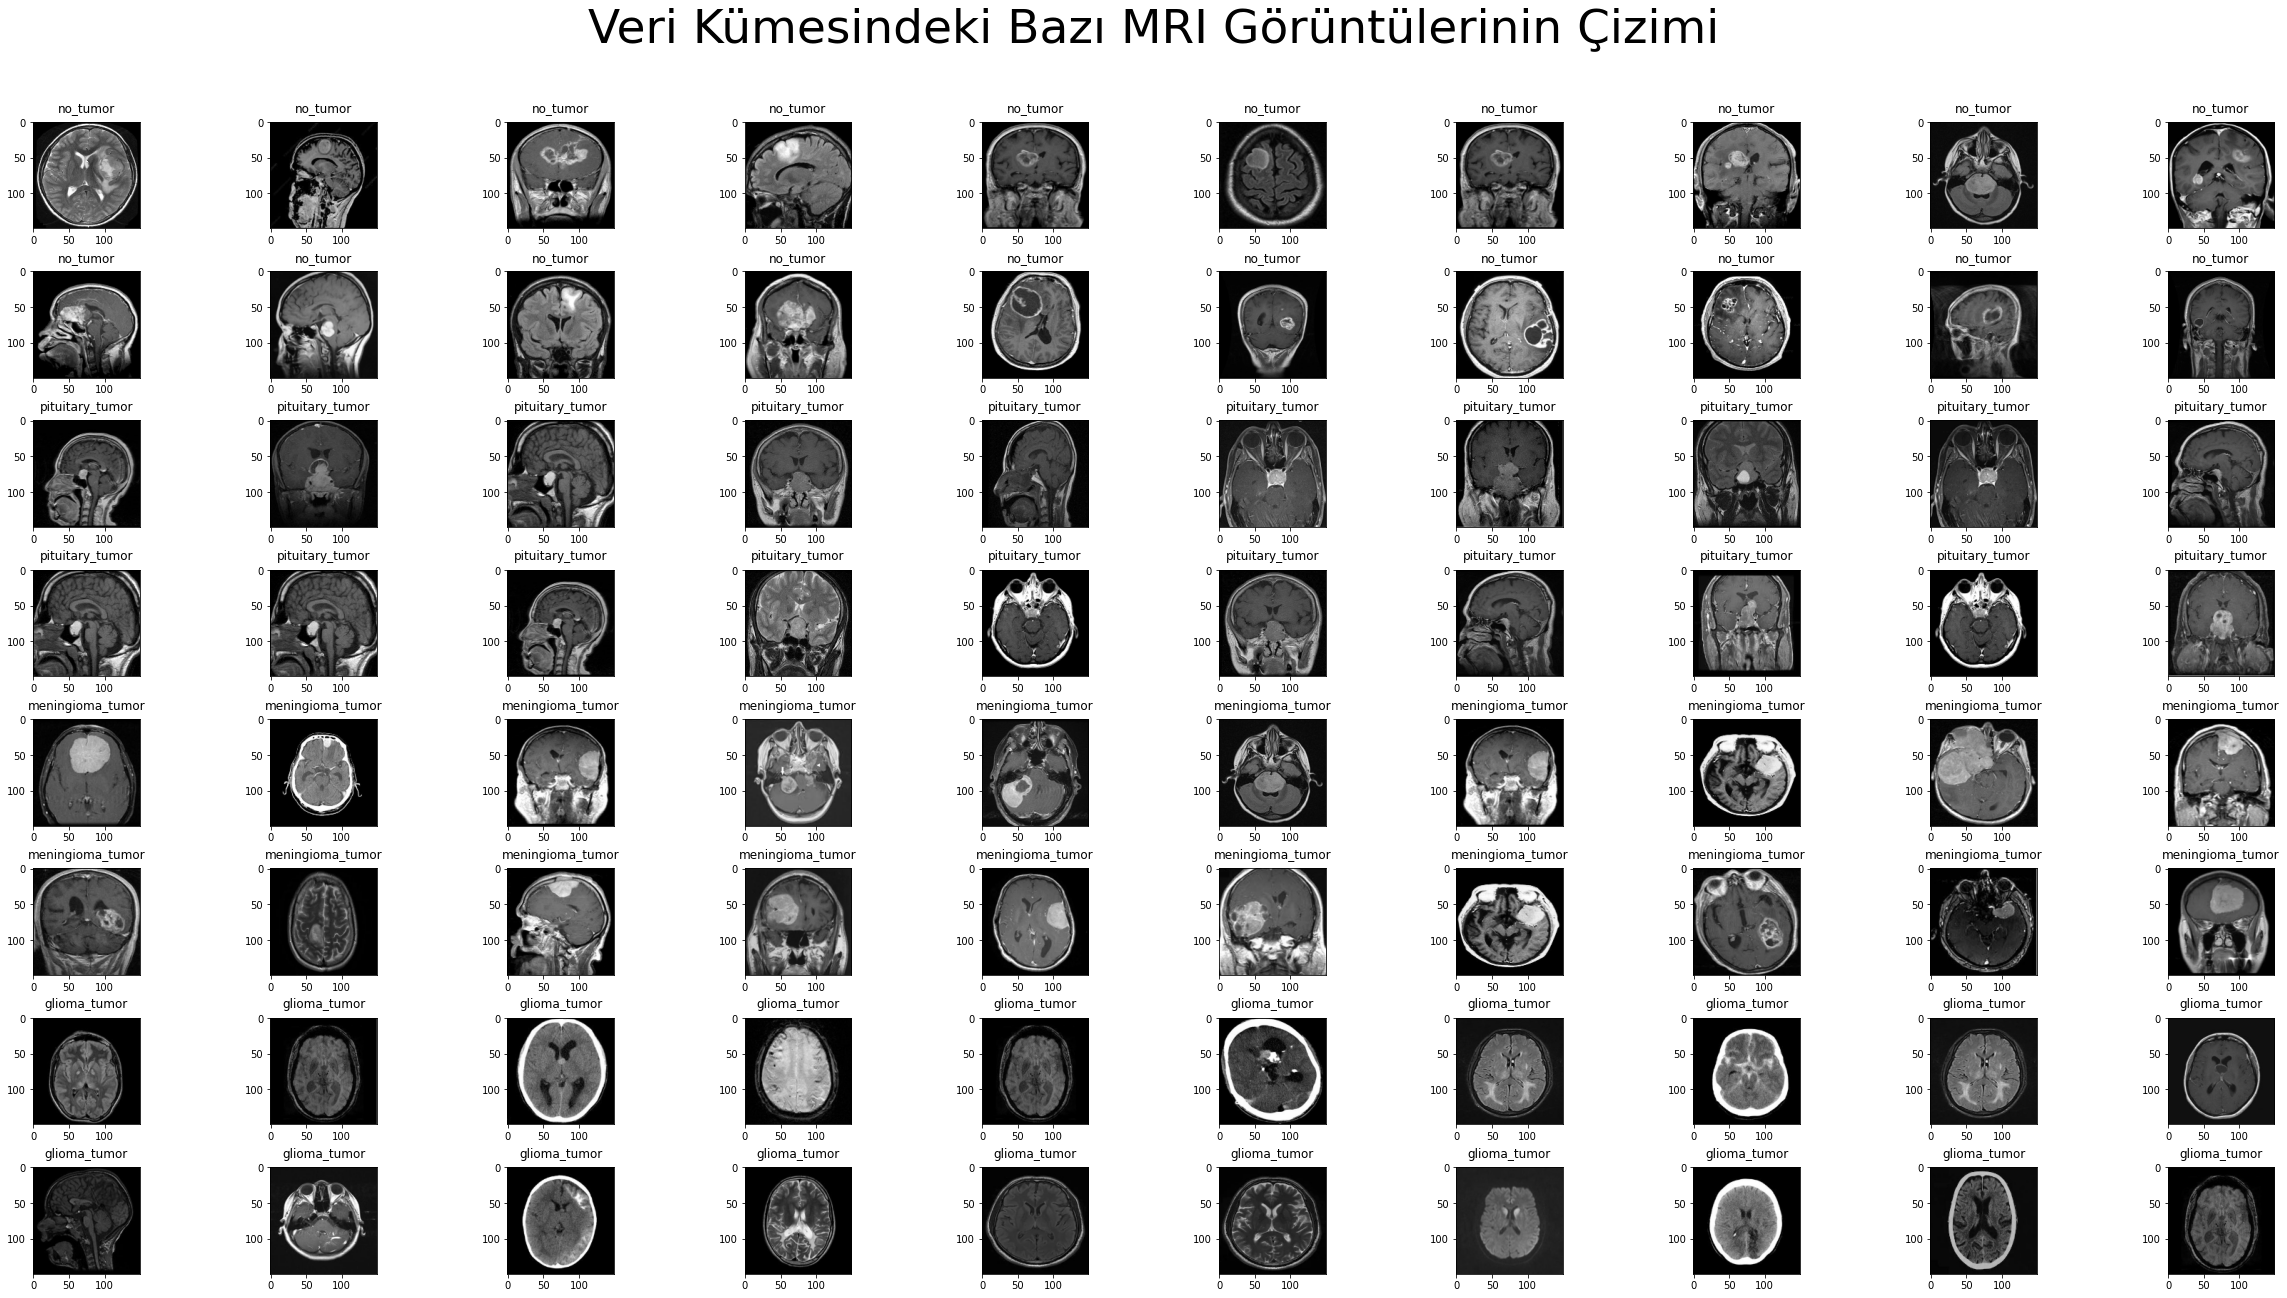

In [ ]:
#Görüntüleri sütunlara ve z_max'a göre çizdirdik.
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Veri Kümesindeki Bazı MRI Görüntülerinin Çizimi',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)

In [ ]:
X_test_images=dict(zip(classes,[[],[],[],[]]))
for y,ele in enumerate(pred_efficent): #pred_vgg, pred_denseNet, pred_inception 
    for i,x in enumerate(X_test_images):
        if ele==i:
            if len(X_test_images[classes[i]])<z_max:
                X_test_images[classes[i]].append(X_test[y])
X_test_images=[X_test_images[i]  for i in X_test_images]

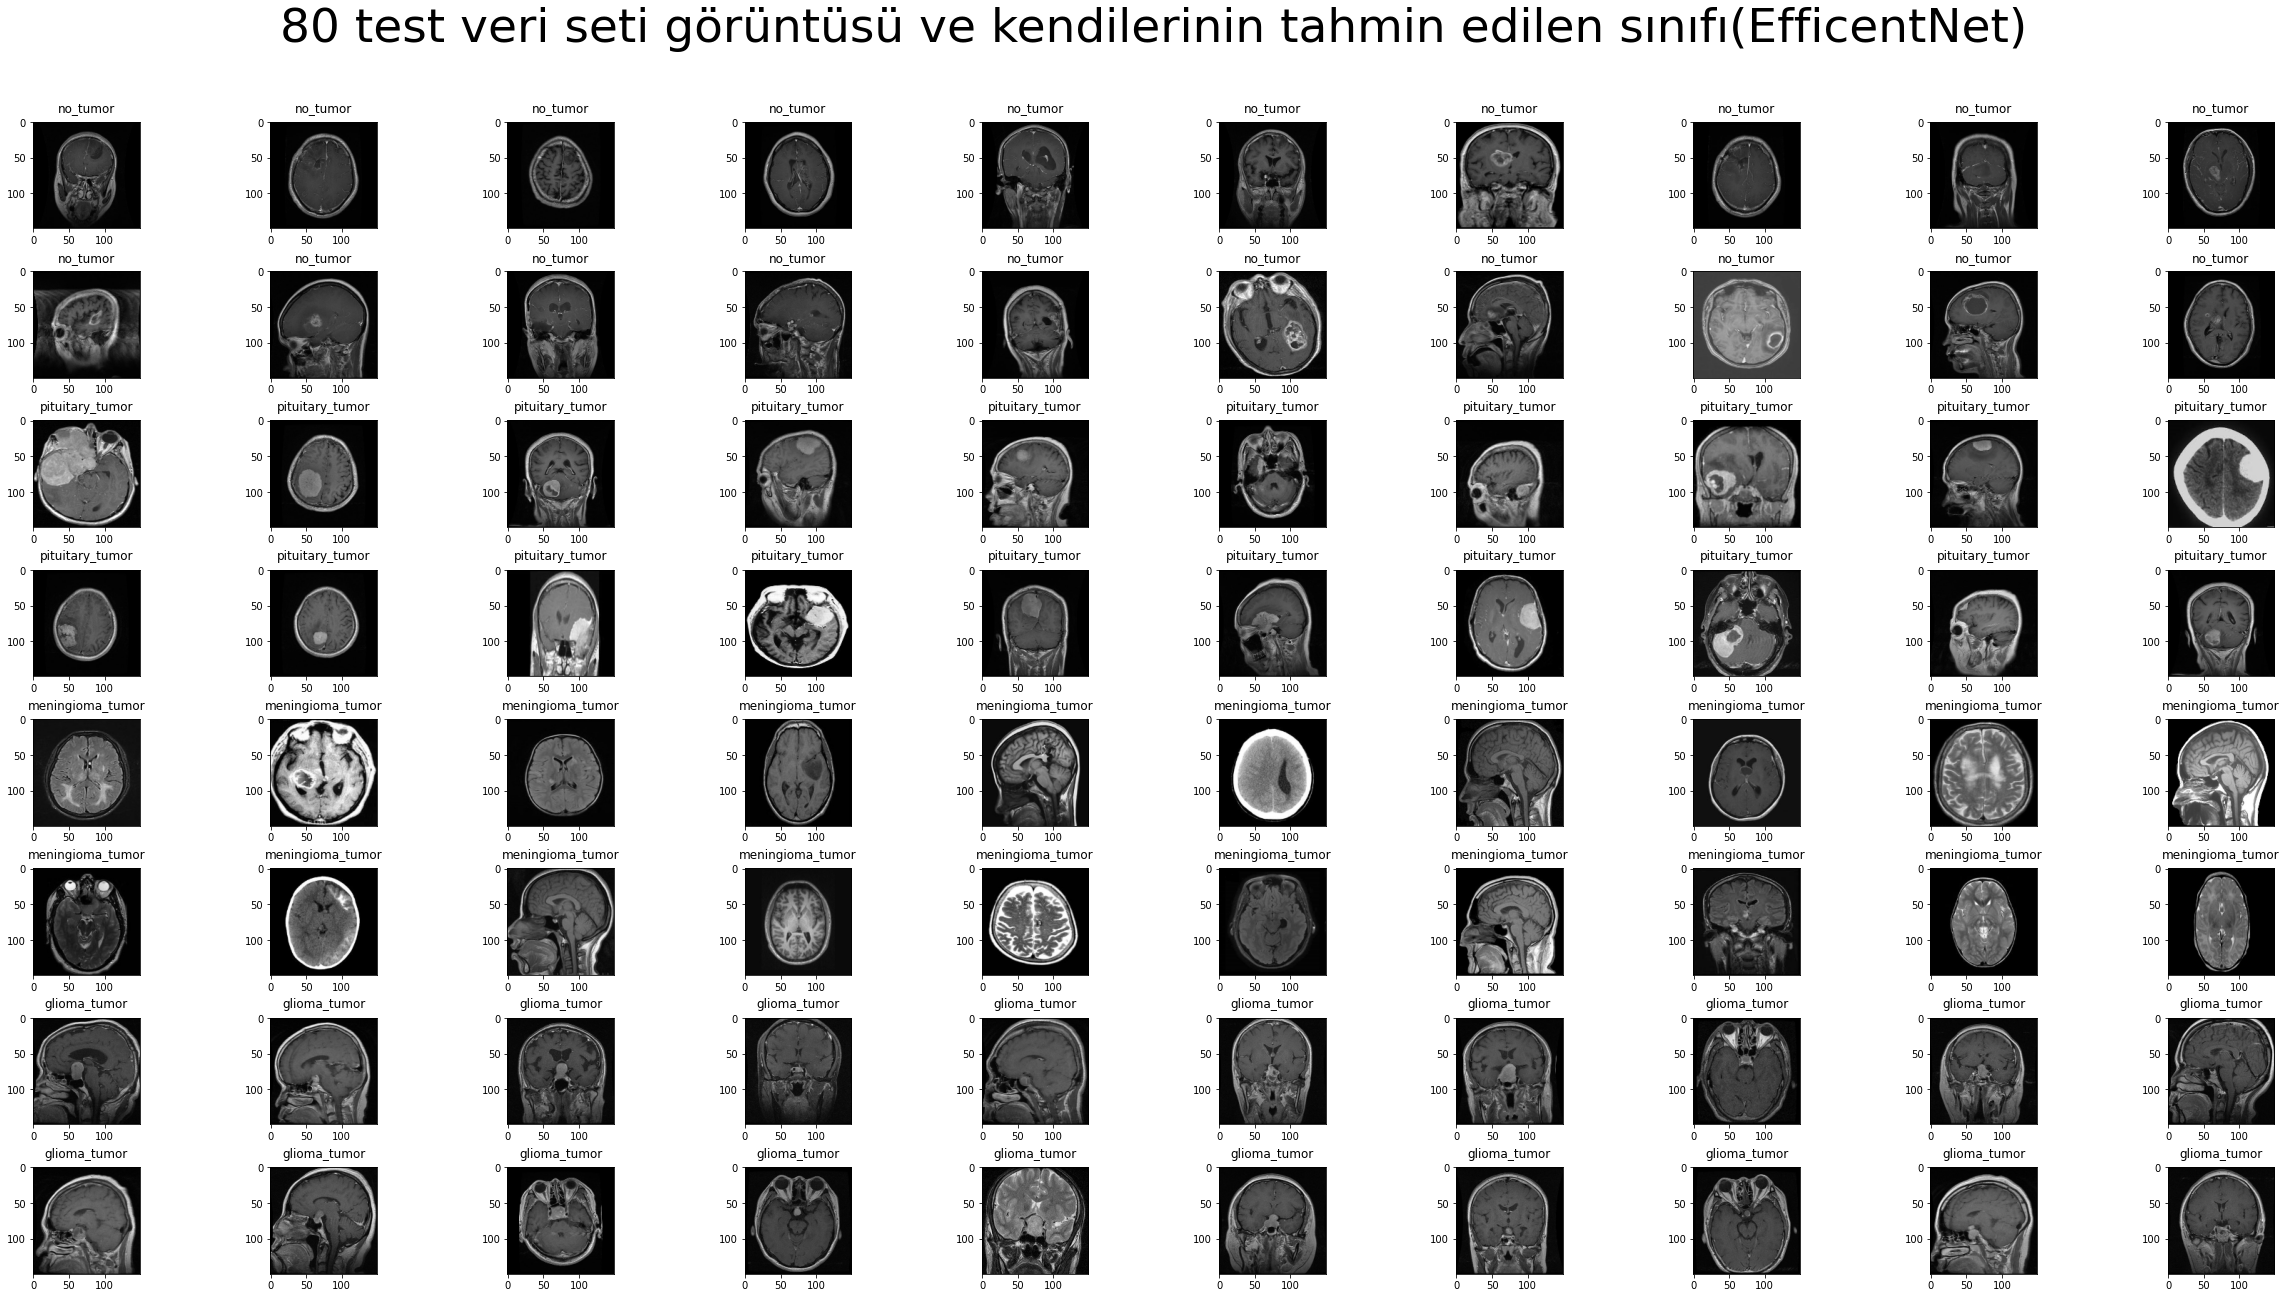

In [ ]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images)*len(X_test_images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images):
    #print(images_class)
    fig.suptitle('80 test veri seti görüntüsü ve kendilerinin tahmin edilen sınıfı(EfficentNet)',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass.png'), dpi=300)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass_white.png'), dpi=300,facecolor='w')

In [ ]:
X_test_images_resnet=dict(zip(classes,[[],[],[],[]]))
for y,ele in enumerate(pred_resnet): #pred_vgg, pred_denseNet, pred_inception  
    for i,x in enumerate(X_test_images_resnet):
        if ele==i:
            if len(X_test_images_resnet[classes[i]])<z_max:
                X_test_images_resnet[classes[i]].append(X_test[y])
X_test_images_resnet=[X_test_images_resnet[i]  for i in X_test_images_resnet]

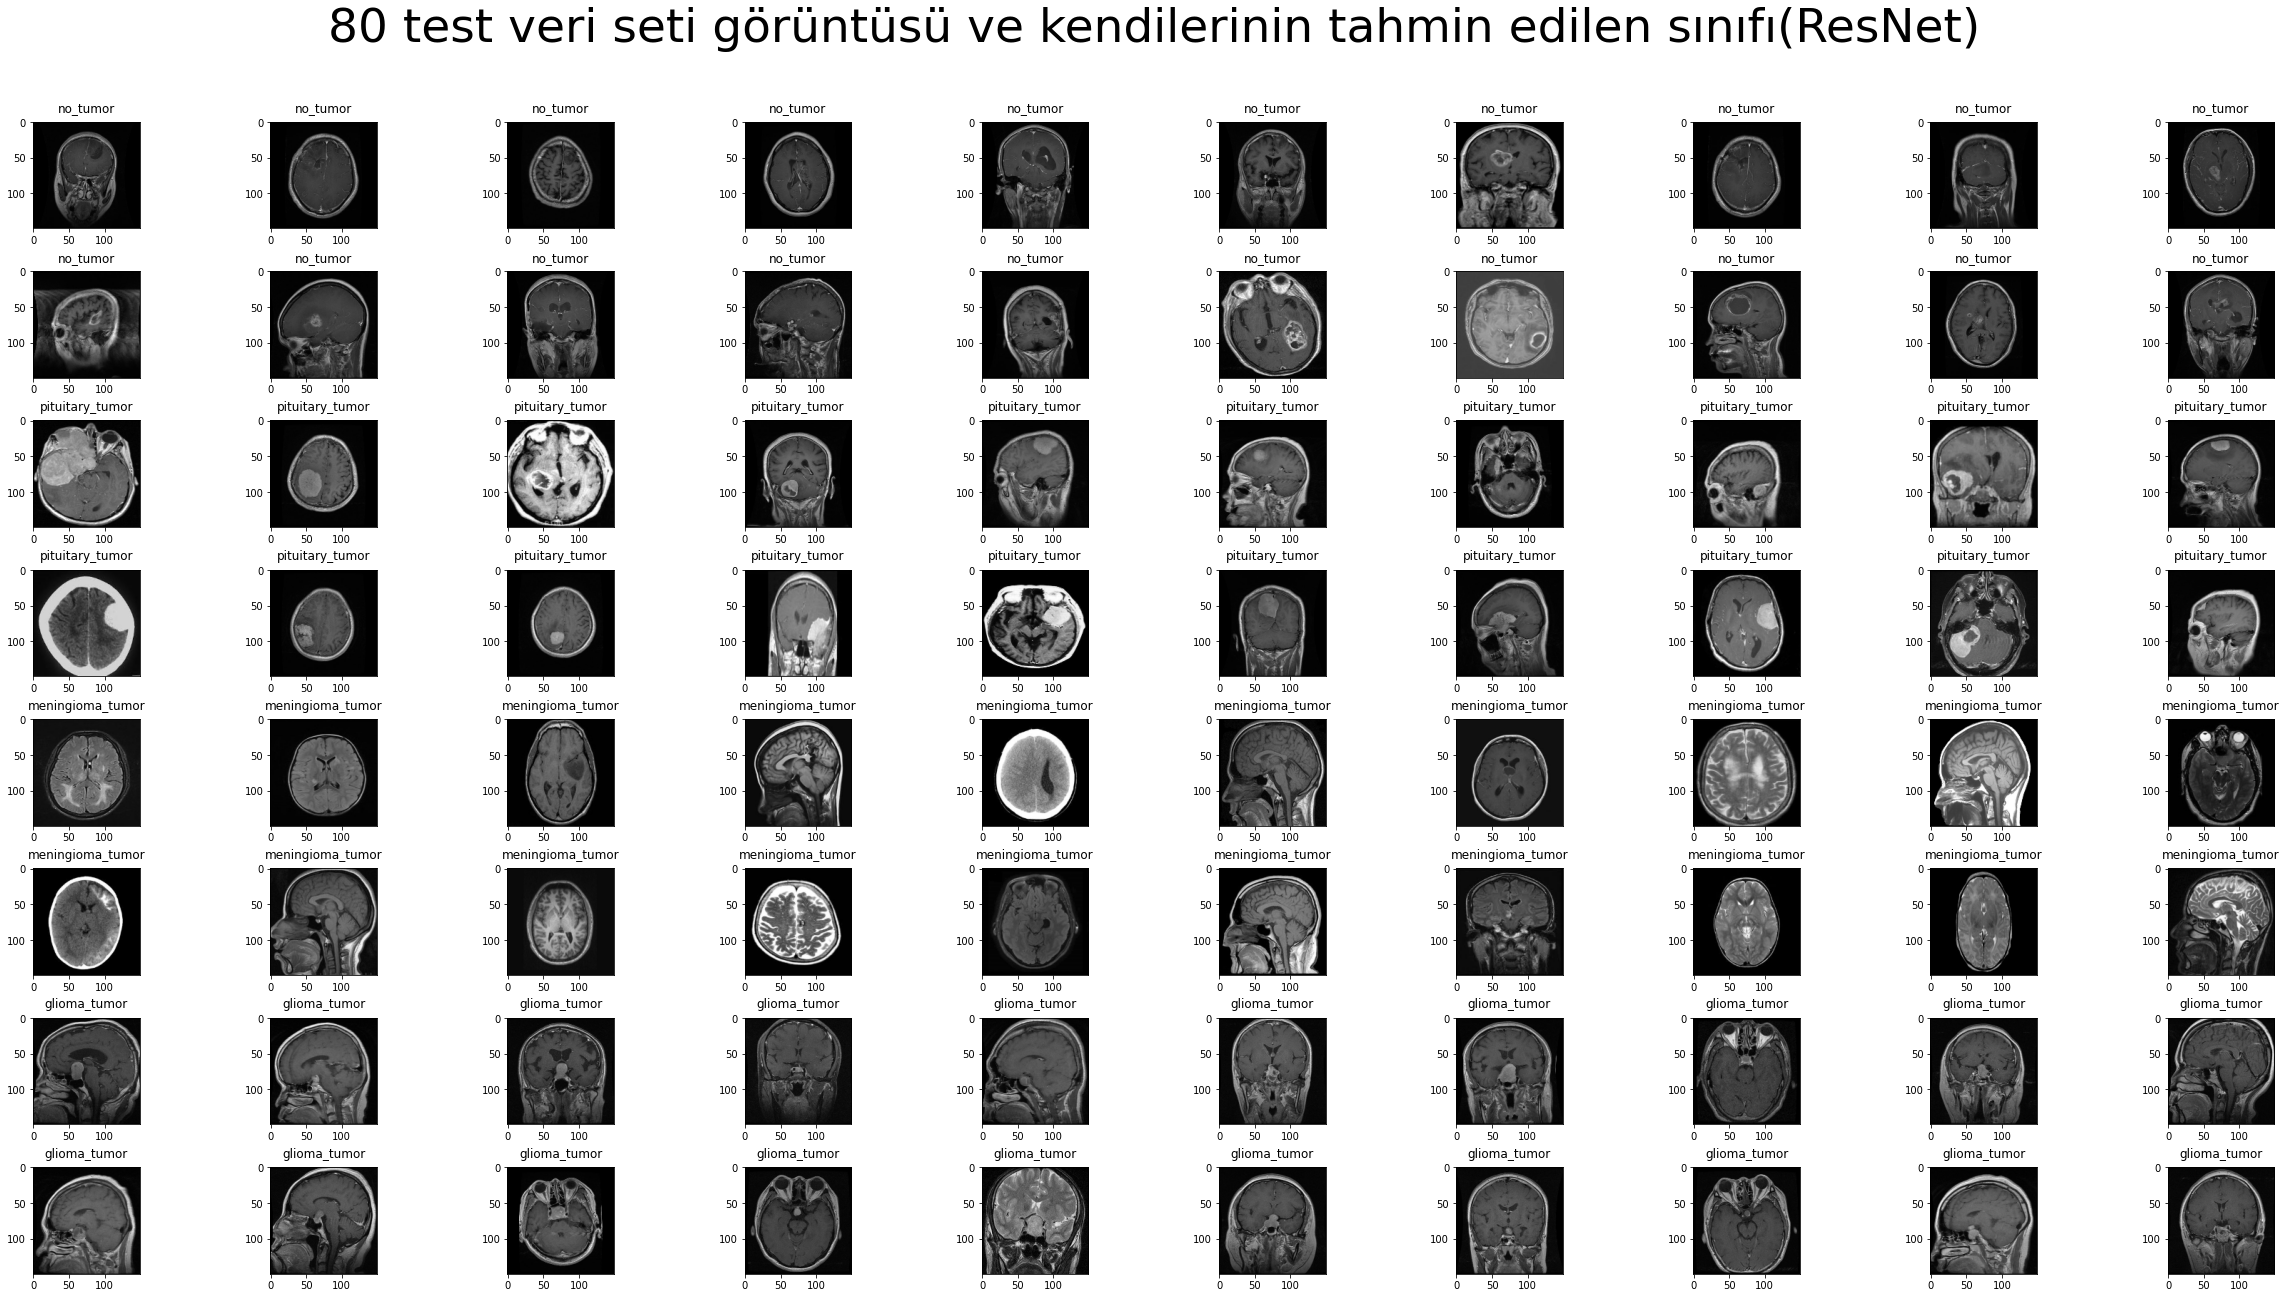

In [ ]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images_resnet)*len(X_test_images_resnet[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images_resnet):
    #print(images_class)
    fig.suptitle('80 test veri seti görüntüsü ve kendilerinin tahmin edilen sınıfı(ResNet)',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)

In [ ]:
X_test.shape

(490, 150, 150, 3)

----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
'''
import logging
from typing import Callable, Dict, List, Optional, Tuple, Union
import torch
from torch import nn
from torch.nn import functional as F

from detectron2.config import configurable
from detectron2.data.detection_utils import get_fed_loss_cls_weights
from detectron2.layers import ShapeSpec, batched_nms, cat, cross_entropy, nonzero_tuple
from detectron2.modeling.box_regression import Box2BoxTransform, _dense_box_regression_loss
from detectron2.structures import Boxes, Instances
from detectron2.utils.events import get_event_storage

__all__ = ["fast_rcnn_inference", "FastRCNNOutputLayers"]


logger = logging.getLogger(__name__)

"""
Shape shorthand in this module:
    N: number of images in the minibatch
    R: number of ROIs, combined over all images, in the minibatch
    Ri: number of ROIs in image i
    K: number of foreground classes. E.g.,there are 80 foreground classes in COCO.
Naming convention:
    deltas: refers to the 4-d (dx, dy, dw, dh) deltas that parameterize the box2box
    transform (see :class:`box_regression.Box2BoxTransform`).
    pred_class_logits: predicted class scores in [-inf, +inf]; use
        softmax(pred_class_logits) to estimate P(class).
    gt_classes: ground-truth classification labels in [0, K], where [0, K) represent
        foreground object classes and K represents the background class.
    pred_proposal_deltas: predicted box2box transform deltas for transforming proposals
        to detection box predictions.
    gt_proposal_deltas: ground-truth box2box transform deltas
"""


def fast_rcnn_inference(
    boxes: List[torch.Tensor],
    scores: List[torch.Tensor],
    image_shapes: List[Tuple[int, int]],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    """
    Call `fast_rcnn_inference_single_image` for all images.
    Args:
        boxes (list[Tensor]): A list of Tensors of predicted class-specific or class-agnostic
            boxes for each image. Element i has shape (Ri, K * 4) if doing
            class-specific regression, or (Ri, 4) if doing class-agnostic
            regression, where Ri is the number of predicted objects for image i.
            This is compatible with the output of :meth:`FastRCNNOutputLayers.predict_boxes`.
        scores (list[Tensor]): A list of Tensors of predicted class scores for each image.
            Element i has shape (Ri, K + 1), where Ri is the number of predicted objects
            for image i. Compatible with the output of :meth:`FastRCNNOutputLayers.predict_probs`.
        image_shapes (list[tuple]): A list of (width, height) tuples for each image in the batch.
        score_thresh (float): Only return detections with a confidence score exceeding this
            threshold.
        nms_thresh (float):  The threshold to use for box non-maximum suppression. Value in [0, 1].
        topk_per_image (int): The number of top scoring detections to return. Set < 0 to return
            all detections.
    Returns:
        instances: (list[Instances]): A list of N instances, one for each image in the batch,
            that stores the topk most confidence detections.
        kept_indices: (list[Tensor]): A list of 1D tensor of length of N, each element indicates
            the corresponding boxes/scores index in [0, Ri) from the input, for image i.
    """
    result_per_image = [
        fast_rcnn_inference_single_image(
            boxes_per_image, scores_per_image, image_shape, score_thresh, nms_thresh, topk_per_image
        )
        for scores_per_image, boxes_per_image, image_shape in zip(scores, boxes, image_shapes)
    ]
    return [x[0] for x in result_per_image], [x[1] for x in result_per_image]


def _log_classification_stats(pred_logits, gt_classes, prefix="fast_rcnn"):
    """
    Log the classification metrics to EventStorage.
    Args:
        pred_logits: Rx(K+1) logits. The last column is for background class.
        gt_classes: R labels
    """
    num_instances = gt_classes.numel()
    if num_instances == 0:
        return
    pred_classes = pred_logits.argmax(dim=1)
    bg_class_ind = pred_logits.shape[1] - 1

    fg_inds = (gt_classes >= 0) & (gt_classes < bg_class_ind)
    num_fg = fg_inds.nonzero().numel()
    fg_gt_classes = gt_classes[fg_inds]
    fg_pred_classes = pred_classes[fg_inds]

    num_false_negative = (fg_pred_classes == bg_class_ind).nonzero().numel()
    num_accurate = (pred_classes == gt_classes).nonzero().numel()
    fg_num_accurate = (fg_pred_classes == fg_gt_classes).nonzero().numel()

    storage = get_event_storage()
    storage.put_scalar(f"{prefix}/cls_accuracy", num_accurate / num_instances)
    if num_fg > 0:
        storage.put_scalar(f"{prefix}/fg_cls_accuracy", fg_num_accurate / num_fg)
        storage.put_scalar(f"{prefix}/false_negative", num_false_negative / num_fg)


def fast_rcnn_inference_single_image(
    boxes,
    scores,
    image_shape: Tuple[int, int],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    """
    Single-image inference. Return bounding-box detection results by thresholding
    on scores and applying non-maximum suppression (NMS).
    Args:
        Same as `fast_rcnn_inference`, but with boxes, scores, and image shapes
        per image.
    Returns:
        Same as `fast_rcnn_inference`, but for only one image.
    """
    valid_mask = torch.isfinite(boxes).all(dim=1) & torch.isfinite(scores).all(dim=1)
    if not valid_mask.all():
        boxes = boxes[valid_mask]
        scores = scores[valid_mask]

    scores = scores[:, :-1]
    num_bbox_reg_classes = boxes.shape[1] // 4
    # Convert to Boxes to use the `clip` function ...
    boxes = Boxes(boxes.reshape(-1, 4))
    boxes.clip(image_shape)
    boxes = boxes.tensor.view(-1, num_bbox_reg_classes, 4)  # R x C x 4

    # 1. Filter results based on detection scores. It can make NMS more efficient
    #    by filtering out low-confidence detections.
    filter_mask = scores > score_thresh  # R x K
    # R' x 2. First column contains indices of the R predictions;
    # Second column contains indices of classes.
    filter_inds = filter_mask.nonzero()
    if num_bbox_reg_classes == 1:
        boxes = boxes[filter_inds[:, 0], 0]
    else:
        boxes = boxes[filter_mask]
    scores = scores[filter_mask]

    # 2. Apply NMS for each class independently.
    keep = batched_nms(boxes, scores, filter_inds[:, 1], nms_thresh)
    if topk_per_image >= 0:
        keep = keep[:topk_per_image]
    boxes, scores, filter_inds = boxes[keep], scores[keep], filter_inds[keep]

    result = Instances(image_shape)
    result.pred_boxes = Boxes(boxes)
    result.scores = scores
    result.pred_classes = filter_inds[:, 1]
    return result, filter_inds[:, 0]


class FastRCNNOutputLayers(nn.Module):
    """
    Two linear layers for predicting Fast R-CNN outputs:
    1. proposal-to-detection box regression deltas
    2. classification scores
    """

    @configurable
    def __init__(
        self,
        input_shape: ShapeSpec,
        *,
        box2box_transform,
        num_classes: int,
        test_score_thresh: float = 0.0,
        test_nms_thresh: float = 0.5,
        test_topk_per_image: int = 100,
        cls_agnostic_bbox_reg: bool = False,
        smooth_l1_beta: float = 0.0,
        box_reg_loss_type: str = "smooth_l1",
        loss_weight: Union[float, Dict[str, float]] = 1.0,
        use_fed_loss: bool = False,
        use_sigmoid_ce: bool = False,
        get_fed_loss_cls_weights: Optional[Callable] = None,
        fed_loss_num_classes: int = 50,
    ):
        """
        NOTE: this interface is experimental.
        Args:
            input_shape (ShapeSpec): shape of the input feature to this module
            box2box_transform (Box2BoxTransform or Box2BoxTransformRotated):
            num_classes (int): number of foreground classes
            test_score_thresh (float): threshold to filter predictions results.
            test_nms_thresh (float): NMS threshold for prediction results.
            test_topk_per_image (int): number of top predictions to produce per image.
            cls_agnostic_bbox_reg (bool): whether to use class agnostic for bbox regression
            smooth_l1_beta (float): transition point from L1 to L2 loss. Only used if
                `box_reg_loss_type` is "smooth_l1"
            box_reg_loss_type (str): Box regression loss type. One of: "smooth_l1", "giou",
                "diou", "ciou"
            loss_weight (float|dict): weights to use for losses. Can be single float for weighting
                all losses, or a dict of individual weightings. Valid dict keys are:
                    * "loss_cls": applied to classification loss
                    * "loss_box_reg": applied to box regression loss
            use_fed_loss (bool): whether to use federated loss which samples additional negative
                classes to calculate the loss
            use_sigmoid_ce (bool): whether to calculate the loss using weighted average of binary
                cross entropy with logits. This could be used together with federated loss
            get_fed_loss_cls_weights (Callable): a callable which takes dataset name and frequency
                weight power, and returns the probabilities to sample negative classes for
                federated loss. The implementation can be found in
                detectron2/data/detection_utils.py
            fed_loss_num_classes (int): number of federated classes to keep in total
        """
        super().__init__()
        if isinstance(input_shape, int):  # some backward compatibility
            input_shape = ShapeSpec(channels=input_shape)
        self.num_classes = num_classes
        input_size = input_shape.channels * (input_shape.width or 1) * (input_shape.height or 1)
        # prediction layer for num_classes foreground classes and one background class (hence + 1)
        self.cls_score = nn.Linear(input_size, num_classes + 1)
        num_bbox_reg_classes = 1 if cls_agnostic_bbox_reg else num_classes
        box_dim = len(box2box_transform.weights)
        self.bbox_pred = nn.Linear(input_size, num_bbox_reg_classes * box_dim)

        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.normal_(self.bbox_pred.weight, std=0.001)
        for l in [self.cls_score, self.bbox_pred]:
            nn.init.constant_(l.bias, 0)

        self.box2box_transform = box2box_transform
        self.smooth_l1_beta = smooth_l1_beta
        self.test_score_thresh = test_score_thresh
        self.test_nms_thresh = test_nms_thresh
        self.test_topk_per_image = test_topk_per_image
        self.box_reg_loss_type = box_reg_loss_type
        if isinstance(loss_weight, float):
            loss_weight = {"loss_cls": loss_weight, "loss_box_reg": loss_weight}
        self.loss_weight = loss_weight
        self.use_fed_loss = use_fed_loss
        self.use_sigmoid_ce = use_sigmoid_ce
        self.fed_loss_num_classes = fed_loss_num_classes

        if self.use_fed_loss:
            assert self.use_sigmoid_ce, "Please use sigmoid cross entropy loss with federated loss"
            fed_loss_cls_weights = get_fed_loss_cls_weights()
            assert (
                len(fed_loss_cls_weights) == self.num_classes
            ), "Please check the provided fed_loss_cls_weights. Their size should match num_classes"
            self.register_buffer("fed_loss_cls_weights", fed_loss_cls_weights)

    @classmethod
    def from_config(cls, cfg, input_shape):
        return {
            "input_shape": input_shape,
            "box2box_transform": Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS),
            # fmt: off
            "num_classes"               : cfg.MODEL.ROI_HEADS.NUM_CLASSES,
            "cls_agnostic_bbox_reg"     : cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG,
            "smooth_l1_beta"            : cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA,
            "test_score_thresh"         : cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST,
            "test_nms_thresh"           : cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST,
            "test_topk_per_image"       : cfg.TEST.DETECTIONS_PER_IMAGE,
            "box_reg_loss_type"         : cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE,
            "loss_weight"               : {"loss_box_reg": cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT},  # noqa
            "use_fed_loss"              : cfg.MODEL.ROI_BOX_HEAD.USE_FED_LOSS,
            "use_sigmoid_ce"            : cfg.MODEL.ROI_BOX_HEAD.USE_SIGMOID_CE,
            "get_fed_loss_cls_weights"  : lambda: get_fed_loss_cls_weights(dataset_names=cfg.DATASETS.TRAIN, freq_weight_power=cfg.MODEL.ROI_BOX_HEAD.FED_LOSS_FREQ_WEIGHT_POWER),  # noqa
            "fed_loss_num_classes"      : cfg.MODEL.ROI_BOX_HEAD.FED_LOSS_NUM_CLASSES,
            # fmt: on
        }

    def forward(self, x):
        """
        Args:
            x: per-region features of shape (N, ...) for N bounding boxes to predict.
        Returns:
            (Tensor, Tensor):
            First tensor: shape (N,K+1), scores for each of the N box. Each row contains the
            scores for K object categories and 1 background class.
            Second tensor: bounding box regression deltas for each box. Shape is shape (N,Kx4),
            or (N,4) for class-agnostic regression.
        """
        if x.dim() > 2:
            x = torch.flatten(x, start_dim=1)
        scores = self.cls_score(x)
        proposal_deltas = self.bbox_pred(x)
        return scores, proposal_deltas

    def losses(self, predictions, proposals):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were used
                to compute predictions. The fields ``proposal_boxes``, ``gt_boxes``,
                ``gt_classes`` are expected.
        Returns:
            Dict[str, Tensor]: dict of losses
        """
        scores, proposal_deltas = predictions

        # parse classification outputs
        gt_classes = (
            cat([p.gt_classes for p in proposals], dim=0) if len(proposals) else torch.empty(0)
        )
        _log_classification_stats(scores, gt_classes)

        # parse box regression outputs
        if len(proposals):
            proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)  # Nx4
            assert not proposal_boxes.requires_grad, "Proposals should not require gradients!"
            # If "gt_boxes" does not exist, the proposals must be all negative and
            # should not be included in regression loss computation.
            # Here we just use proposal_boxes as an arbitrary placeholder because its
            # value won't be used in self.box_reg_loss().
            gt_boxes = cat(
                [(p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes).tensor for p in proposals],
                dim=0,
            )
        else:
            proposal_boxes = gt_boxes = torch.empty((0, 4), device=proposal_deltas.device)

        if self.use_sigmoid_ce:
            loss_cls = self.sigmoid_cross_entropy_loss(scores, gt_classes)
        else:
            loss_cls = cross_entropy(scores, gt_classes, reduction="mean")

        losses = {
            "loss_cls": loss_cls,
            "loss_box_reg": self.box_reg_loss(
                proposal_boxes, gt_boxes, proposal_deltas, gt_classes
            ),
        }
        return {k: v * self.loss_weight.get(k, 1.0) for k, v in losses.items()}

    # Implementation from https://github.com/xingyizhou/CenterNet2/blob/master/projects/CenterNet2/centernet/modeling/roi_heads/fed_loss.py  # noqa
    # with slight modifications
    def get_fed_loss_classes(self, gt_classes, num_fed_loss_classes, num_classes, weight):
        """
        Args:
            gt_classes: a long tensor of shape R that contains the gt class label of each proposal.
            num_fed_loss_classes: minimum number of classes to keep when calculating federated loss.
            Will sample negative classes if number of unique gt_classes is smaller than this value.
            num_classes: number of foreground classes
            weight: probabilities used to sample negative classes
        Returns:
            Tensor:
                classes to keep when calculating the federated loss, including both unique gt
                classes and sampled negative classes.
        """
        unique_gt_classes = torch.unique(gt_classes)
        prob = unique_gt_classes.new_ones(num_classes + 1).float()
        prob[-1] = 0
        if len(unique_gt_classes) < num_fed_loss_classes:
            prob[:num_classes] = weight.float().clone()
            prob[unique_gt_classes] = 0
            sampled_negative_classes = torch.multinomial(
                prob, num_fed_loss_classes - len(unique_gt_classes), replacement=False
            )
            fed_loss_classes = torch.cat([unique_gt_classes, sampled_negative_classes])
        else:
            fed_loss_classes = unique_gt_classes
        return fed_loss_classes

    # Implementation from https://github.com/xingyizhou/CenterNet2/blob/master/projects/CenterNet2/centernet/modeling/roi_heads/custom_fast_rcnn.py#L113  # noqa
    # with slight modifications
    def sigmoid_cross_entropy_loss(self, pred_class_logits, gt_classes):
        """
        Args:
            pred_class_logits: shape (N, K+1), scores for each of the N box. Each row contains the
            scores for K object categories and 1 background class
            gt_classes: a long tensor of shape R that contains the gt class label of each proposal.
        """
        if pred_class_logits.numel() == 0:
            return pred_class_logits.new_zeros([1])[0]

        N = pred_class_logits.shape[0]
        K = pred_class_logits.shape[1] - 1

        target = pred_class_logits.new_zeros(N, K + 1)
        target[range(len(gt_classes)), gt_classes] = 1
        target = target[:, :K]

        cls_loss = F.binary_cross_entropy_with_logits(
            pred_class_logits[:, :-1], target, reduction="none"
        )

        if self.use_fed_loss:
            fed_loss_classes = self.get_fed_loss_classes(
                gt_classes,
                num_fed_loss_classes=self.fed_loss_num_classes,
                num_classes=K,
                weight=self.fed_loss_cls_weights,
            )
            fed_loss_classes_mask = fed_loss_classes.new_zeros(K + 1)
            fed_loss_classes_mask[fed_loss_classes] = 1
            fed_loss_classes_mask = fed_loss_classes_mask[:K]
            weight = fed_loss_classes_mask.view(1, K).expand(N, K).float()
        else:
            weight = 1

        loss = torch.sum(cls_loss * weight) / N
        return loss

    def box_reg_loss(self, proposal_boxes, gt_boxes, pred_deltas, gt_classes):
        """
        Args:
            proposal_boxes/gt_boxes are tensors with the same shape (R, 4 or 5).
            pred_deltas has shape (R, 4 or 5), or (R, num_classes * (4 or 5)).
            gt_classes is a long tensor of shape R, the gt class label of each proposal.
            R shall be the number of proposals.
        """
        box_dim = proposal_boxes.shape[1]  # 4 or 5
        # Regression loss is only computed for foreground proposals (those matched to a GT)
        fg_inds = nonzero_tuple((gt_classes >= 0) & (gt_classes < self.num_classes))[0]
        if pred_deltas.shape[1] == box_dim:  # cls-agnostic regression
            fg_pred_deltas = pred_deltas[fg_inds]
        else:
            fg_pred_deltas = pred_deltas.view(-1, self.num_classes, box_dim)[
                fg_inds, gt_classes[fg_inds]
            ]

        loss_box_reg = _dense_box_regression_loss(
            [proposal_boxes[fg_inds]],
            self.box2box_transform,
            [fg_pred_deltas.unsqueeze(0)],
            [gt_boxes[fg_inds]],
            ...,
            self.box_reg_loss_type,
            self.smooth_l1_beta,
        )

        # The reg loss is normalized using the total number of regions (R), not the number
        # of foreground regions even though the box regression loss is only defined on
        # foreground regions. Why? Because doing so gives equal training influence to
        # each foreground example. To see how, consider two different minibatches:
        #  (1) Contains a single foreground region
        #  (2) Contains 100 foreground regions
        # If we normalize by the number of foreground regions, the single example in
        # minibatch (1) will be given 100 times as much influence as each foreground
        # example in minibatch (2). Normalizing by the total number of regions, R,
        # means that the single example in minibatch (1) and each of the 100 examples
        # in minibatch (2) are given equal influence.
        return loss_box_reg / max(gt_classes.numel(), 1.0)  # return 0 if empty

    def inference(self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions. The ``proposal_boxes`` field is expected.
        Returns:
            list[Instances]: same as `fast_rcnn_inference`.
            list[Tensor]: same as `fast_rcnn_inference`.
        """
        boxes = self.predict_boxes(predictions, proposals)
        scores = self.predict_probs(predictions, proposals)
        image_shapes = [x.image_size for x in proposals]
        return fast_rcnn_inference(
            boxes,
            scores,
            image_shapes,
            self.test_score_thresh,
            self.test_nms_thresh,
            self.test_topk_per_image,
        )

    def predict_boxes_for_gt_classes(self, predictions, proposals):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were used
                to compute predictions. The fields ``proposal_boxes``, ``gt_classes`` are expected.
        Returns:
            list[Tensor]:
                A list of Tensors of predicted boxes for GT classes in case of
                class-specific box head. Element i of the list has shape (Ri, B), where Ri is
                the number of proposals for image i and B is the box dimension (4 or 5)
        """
        if not len(proposals):
            return []
        scores, proposal_deltas = predictions
        proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)
        N, B = proposal_boxes.shape
        predict_boxes = self.box2box_transform.apply_deltas(
            proposal_deltas, proposal_boxes
        )  # Nx(KxB)

        K = predict_boxes.shape[1] // B
        if K > 1:
            gt_classes = torch.cat([p.gt_classes for p in proposals], dim=0)
            # Some proposals are ignored or have a background class. Their gt_classes
            # cannot be used as index.
            gt_classes = gt_classes.clamp_(0, K - 1)

            predict_boxes = predict_boxes.view(N, K, B)[
                torch.arange(N, dtype=torch.long, device=predict_boxes.device), gt_classes
            ]
        num_prop_per_image = [len(p) for p in proposals]
        return predict_boxes.split(num_prop_per_image)

    def predict_boxes(
        self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
    ):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions. The ``proposal_boxes`` field is expected.
        Returns:
            list[Tensor]:
                A list of Tensors of predicted class-specific or class-agnostic boxes
                for each image. Element i has shape (Ri, K * B) or (Ri, B), where Ri is
                the number of proposals for image i and B is the box dimension (4 or 5)
        """
        if not len(proposals):
            return []
        _, proposal_deltas = predictions
        num_prop_per_image = [len(p) for p in proposals]
        proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)
        predict_boxes = self.box2box_transform.apply_deltas(
            proposal_deltas,
            proposal_boxes,
        )  # Nx(KxB)
        return predict_boxes.split(num_prop_per_image)

    def predict_probs(
        self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
    ):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions.
        Returns:
            list[Tensor]:
                A list of Tensors of predicted class probabilities for each image.
                Element i has shape (Ri, K + 1), where Ri is the number of proposals for image i.
        """
        scores, _ = predictions
        num_inst_per_image = [len(p) for p in proposals]
        if self.use_sigmoid_ce:
            probs = scores.sigmoid()
        else:
            probs = F.softmax(scores, dim=-1)
        return probs.split(num_inst_per_image, dim=0)

'''

'\nimport logging\nfrom typing import Callable, Dict, List, Optional, Tuple, Union\nimport torch\nfrom torch import nn\nfrom torch.nn import functional as F\n\nfrom detectron2.config import configurable\nfrom detectron2.data.detection_utils import get_fed_loss_cls_weights\nfrom detectron2.layers import ShapeSpec, batched_nms, cat, cross_entropy, nonzero_tuple\nfrom detectron2.modeling.box_regression import Box2BoxTransform, _dense_box_regression_loss\nfrom detectron2.structures import Boxes, Instances\nfrom detectron2.utils.events import get_event_storage\n\n__all__ = ["fast_rcnn_inference", "FastRCNNOutputLayers"]\n\n\nlogger = logging.getLogger(__name__)\n\n"""\nShape shorthand in this module:\n    N: number of images in the minibatch\n    R: number of ROIs, combined over all images, in the minibatch\n    Ri: number of ROIs in image i\n    K: number of foreground classes. E.g.,there are 80 foreground classes in COCO.\nNaming convention:\n    deltas: refers to the 4-d (dx, dy, dw, dh)